In [1]:
!pip install adversarial-robustness-toolbox --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.0 MB/s eta 0:00:00a 0:00:01



In [2]:
import warnings

warnings.filterwarnings('ignore')

In [14]:
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPool2D, BatchNormalization
from keras.losses import CategoricalCrossentropy
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

In [4]:
from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import TensorFlowV2Classifier

In [5]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [10]:
def create_model():
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation='softmax'))
  return model

In [8]:
model = create_model()
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 26, 26, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 11, 11, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 3, 3, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 164,746 (643.54 KB)

 Trainable params: 164,298 (641.79 KB)

 Non-trainable params: 448 (1.75 KB)

In [12]:
loss_obj = CategoricalCrossentropy()
classifier = TensorFlowV2Classifier(
    model=model,
    loss_object=loss_obj,
    nb_classes=10,
    input_shape=(28,28,1),
    clip_values=(0, 1)

)

In [13]:
attack = ProjectedGradientDescent(
    classifier,
    eps=0.3,
    eps_step=0.01,
    max_iter=40,
    targeted=False,
    num_random_init=True
)

In [32]:
X_train_adv = attack.generate(X_train)


PGD - Batches: 0it [00:00, ?it/s]

In [16]:
import matplotlib.pyplot as plt

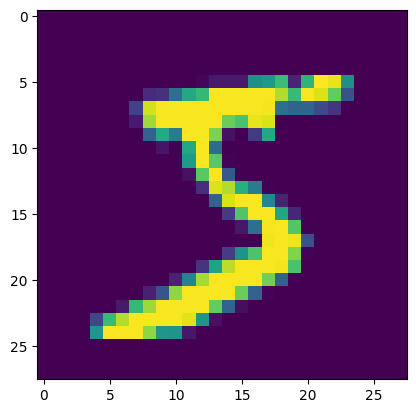

In [18]:
plt.imshow(X_train[0].squeeze())

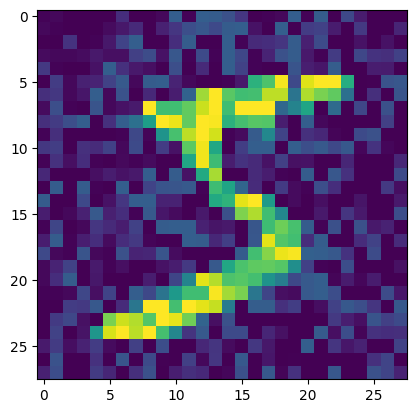

In [19]:
plt.imshow(X_train_adv[0].squeeze())

In [34]:
X_train_poisoned = np.concatenate((X_train, X_train_adv), axis=0)
y_train_poisoned = np.concatenate((y_train, y_train), axis=0)

In [21]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)

In [35]:
history = model.fit(X_train_poisoned, y_train_poisoned, batch_size=128, epochs=10, validation_data=(X_test, y_test), callbacks=[learning_rate_reduction])

Epoch 1/10

938/938 ━━━━━━━━━━━━━━━━━━━━ 166s 177ms/step - accuracy: 0.8663 - loss: 0.7586 - val_accuracy: 0.9816 - val_loss: 0.0617 - learning_rate: 2.5000e-04

Epoch 2/10

938/938 ━━━━━━━━━━━━━━━━━━━━ 201s 175ms/step - accuracy: 0.9646 - loss: 0.1103 - val_accuracy: 0.9834 - val_loss: 0.0567 - learning_rate: 2.5000e-04

Epoch 3/10

938/938 ━━━━━━━━━━━━━━━━━━━━ 194s 167ms/step - accuracy: 0.9812 - loss: 0.0578 - val_accuracy: 0.9845 - val_loss: 0.0539 - learning_rate: 2.5000e-04

Epoch 4/10

938/938 ━━━━━━━━━━━━━━━━━━━━ 154s 164ms/step - accuracy: 0.9877 - loss: 0.0388 - val_accuracy: 0.9869 - val_loss: 0.0474 - learning_rate: 2.5000e-04

Epoch 5/10

938/938 ━━━━━━━━━━━━━━━━━━━━ 152s 162ms/step - accuracy: 0.9910 - loss: 0.0282 - val_accuracy: 0.9872 - val_loss: 0.0478 - learning_rate: 2.5000e-04

Epoch 6/10

938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9933 - loss: 0.0209

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

938/938 ━━━━━━━━━━━━━━━

In [36]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy on benign data: {test_accuracy:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9847 - loss: 0.0694

Test accuracy on benign data: 0.9884


In [24]:
X_test_adv = attack.generate(X_test)

PGD - Batches: 0it [00:00, ?it/s]

In [37]:
test_loss, test_accuracy = model.evaluate(X_test_adv, y_test)
print(f"Test accuracy on benign data: {test_accuracy:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9796 - loss: 0.1017

Test accuracy on benign data: 0.9839


In [39]:
model.save("adversarial_defender.keras")

In [40]:
from google.colab import files

In [41]:
files.download("adversarial_defender.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>